# PIK3CA: Effects of Mutation on PDK1

<b> Standard imports for playing with and plotting data frames. </b>

In [13]:
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
import re
import statsmodels.stats.multitest

<b> Import CPTAC data </b>

In [14]:
import CPTAC

In [15]:
somatic_mutations = CPTAC.get_somatic()
#print(somatic_mutations)


proteomics = CPTAC.get_proteomics()
#print(proteomics)


phos = CPTAC.get_phosphoproteomics()
#print(phos)

# PI3KCA mutation and PDK1 proteome abundance 

<b> Take out the control </b>

In [16]:
proteomics = proteomics[:100]

### Perform a t-test with mutated and non-mutated protein levels

In [17]:
protList = ['PDK1']
pcutoff = 0.05 / len(protList)
gene = 'PIK3CA'

sigResults = [];
for protein in protList: 
    if protein in proteomics.columns:
        cross = CPTAC.compare_mutations(proteomics, protein, gene)
        cross = cross[["Mutation", protein]].dropna(axis=0)
        mutated = cross.loc[cross["Mutation"] == "Missense_Mutation"]
        wt = cross.loc[cross["Mutation"] == "Wildtype"]
        ttest = scipy.stats.ttest_ind(mutated[protein], wt[protein])
        if(ttest[1] <= pcutoff):
            sigResults.append(protein)
            print("Test for " + protein + ": ")
            print(ttest) 
        else:
            print("Unsignificant result for " + protein + ": ")
            print(ttest) 
            

Unsignificant result for PDK1: 
Ttest_indResult(statistic=1.7775274053859993, pvalue=0.07868159328040479)


 ### We can now plot the data 

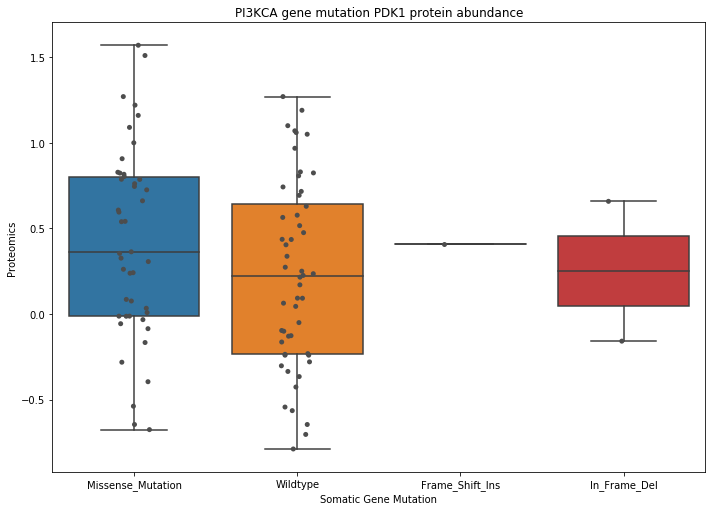

In [18]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
somatic_boxplot = sns.boxplot(data=cross, x="Mutation",y=protein, ax = ax)
somatic_boxplot.set_title("PI3KCA gene mutation PDK1 protein abundance")
somatic_boxplot = sns.stripplot(data=cross, x="Mutation", y=protein,jitter=True, color=".3")
somatic_boxplot.set(xlabel="Somatic Gene Mutation",ylabel="Proteomics")
plt.show()

# PI3KCA mutation and PDK1 phosphoproteome abundance 

In [25]:
sites = phos.columns
p_values = []
site_names = []
phosProtList = ['PDK1']

alpha = 0.05
p_value = alpha/len(phosProtList)

#print(CPTAC.compare_mutations(phos, 'PDK', gene))


for protein in phosProtList:
    pattern = re.compile(protein)
    isInList = filter(pattern.search, sites)
    if next(isInList, None) is not None:
        print('yes')
        phosphositesdf = CPTAC.compare_mutations(phos, protein, gene)
        phosphositesdf = phosphositesdf.loc[phosphositesdf['Patient_Type'] == 'Tumor'].drop('Patient_Type', axis = 1)
        
        for site in phosphositesdf.columns:
            if (site is not 'Mutation'):
                sitedf = CPTAC.compare_mutations(phos, site, gene)
               # print(sitedf)
                mutateddf = sitedf.loc[sitedf['Mutation'] != 'Wildtype'].dropna(axis=0)
                #print(mutateddf)
                wtdf = sitedf.loc[sitedf['Mutation'] == 'Wildtype'].dropna(axis=0)
                ttest = scipy.stats.ttest_ind(mutateddf[site], wtdf[site])
                p_values.append(ttest[1])
                site_names.append(site)     
                
#We need to remove all 'nan' p-values and their corresponding site names before passing it in for the fdr correction
indexesToRemove=[]

for index in range(0, len(p_values)):
    if np.isnan(p_values[index]):
        indexesToRemove.append(index)

for rem in range( len(indexesToRemove)-1, -1, -1):
    p_values.pop(indexesToRemove[rem])
    site_names.pop(indexesToRemove[rem])
#p_values and site names have now had all entries removed where the corresponding p-value is 'nan'
        

pvalues = statsmodels.stats.multitest.fdrcorrection(p_values,alpha=0.05, method='indep')[1]         
areSignificant = statsmodels.stats.multitest.fdrcorrection(p_values,alpha=0.05, method='indep')[0]

significant_sites = np.array(site_names)[np.array(areSignificant)]
significant_pvalues = np.array(pvalues)[np.array(areSignificant)]

significant_vals = dict(zip(significant_sites, significant_pvalues))

print(significant_sites)
print(significant_pvalues)
print(significant_vals)

Gene PDK not found in phosphoproteomics data


AttributeError: 'NoneType' object has no attribute 'columns'